# Runtime comparisons for duplicate node exclusion methods

Here, we optimize our neo4j queries by comparing multiple methods of duplicate node exlusion. We compare three methods, as [described here](https://doi.org/10.15363/thinklab.d134#2), as well as no duplicate node constraint.

In [1]:
import itertools

import numpy
import pandas
import matplotlib.pyplot
import seaborn

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
seaborn.set_style('whitegrid')
%matplotlib inline

In [3]:
feature_df = pandas.read_table('dwpc.tsv.gz', nrows=None)

In [4]:
# Create a spread dataframe of runtimes
runtime_df = feature_df.pivot_table(values='seconds', index=['compound_id', 'disease_id', 'metapath'], columns='unique_nodes')
runtime_df = runtime_df.dropna() # use if only reading a part of `dwpc.tsv.gz`
logtime_df = numpy.log10(runtime_df)

## Average query runtime by method

In [5]:
# milliseconds per query
(1000 * runtime_df.mean()).sort_values()

unique_nodes
False       129.412904
labeled     143.564091
expanded    173.433164
nested      179.764443
dtype: float64

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


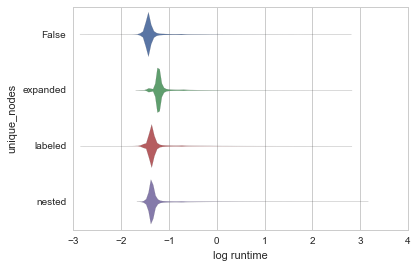

In [6]:
ax = seaborn.violinplot(x='value', y='unique_nodes', data=pandas.melt(logtime_df), inner=None, cut=0, linewidth=0.1)
matplotlib.pylab.xlabel('log runtime');

## 2D histograms comparing runtime across methods

Both runtime and density are log transformed.

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


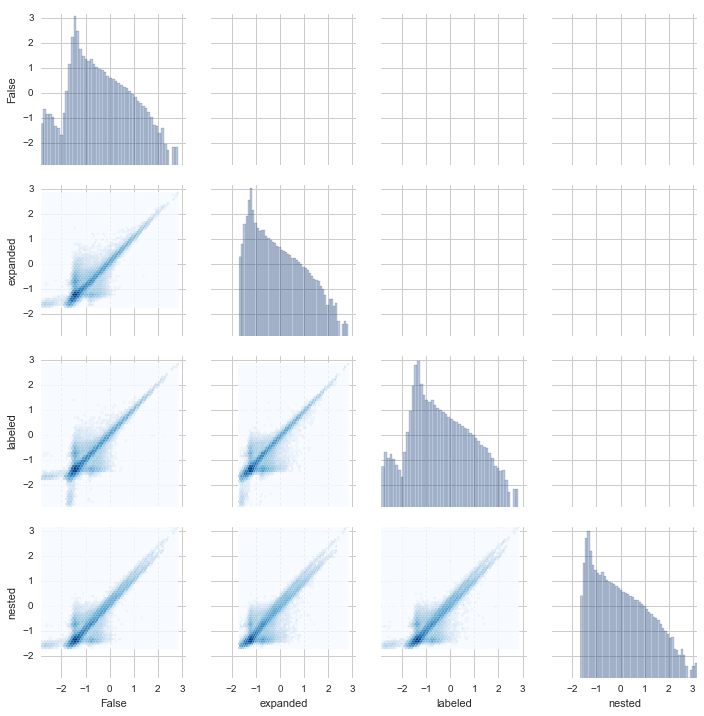

In [7]:
grid = seaborn.PairGrid(logtime_df)
grid.map_diag(seaborn.distplot, kde=False, hist_kws={'log': True})
grid.map_lower(matplotlib.pyplot.hexbin, bins='log', cmap='Blues', gridsize=50, linewidths=0)
lim = logtime_df.min().min(), logtime_df.max().max()
grid.set(xlim=lim, ylim=lim)
seaborn.despine(top=True, right=True, left=True, bottom=True)

## Compare runtime differences between methods

Runtime differences are transformed using the [inverse hyperbolic sine transformation](https://doi.org/10.2307/2288929), which is zero-preserving. We chose a high value of θ to severely compress long runtimes.

In [8]:
methods = 'False', 'nested', 'expanded', 'labeled'

paired_columns = []
for a, b in itertools.combinations(methods, 2):
    key = '{} - {}'.format(a, b)
    runtime_df[key] = runtime_df[a] - runtime_df[b]
    paired_columns.append(key)

/home/dhimmels/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


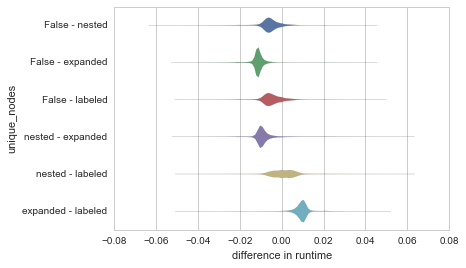

In [9]:
# IHS transformation
theta = 200
paired_df = numpy.arcsinh(theta * runtime_df[paired_columns]) / theta

# Violin plots
ax = seaborn.violinplot(x='value', y='unique_nodes', data=pandas.melt(paired_df), inner=None, cut=0, linewidth=0.1)
matplotlib.pylab.xlabel('difference in runtime');